# Load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score


In [2]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)


['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [3]:
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv("y_test.csv")

x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

y_data_np = np.concatenate((y_train_np, y_test_np), axis=0)


# Question 1

In [4]:
def gini(sequence):
    sequence_0 = sequence[np.where(sequence == 0)]
    sequence_1 = sequence[np.where(sequence == 1)]
    p_0 = sequence_0.size / sequence.size
    p_1 = sequence_1.size / sequence.size
    return 1 - p_0 ** 2 - p_1 ** 2


def entropy(sequence):
    sequence_0 = sequence[np.where(sequence == 0)]
    sequence_1 = sequence[np.where(sequence == 1)]
    p_0 = sequence_0.size / sequence.size
    p_1 = sequence_1.size / sequence.size
    return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))

# I used all given datas to calculate Gini index and entropy
print("Gini of data is ", gini(y_data_np))
print("Entropy of data is ", entropy(y_data_np))


Gini of data is  0.46753006075469244
Entropy of data is  0.9526351224018599


# Question 2

In [5]:
# The node used in decision tree
class Node:
    def __init__(self, gini, entropy, num_samples,
                 num_samples_per_class, predicted_class):
        self.gini = gini
        self.entropy = entropy
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None


In [6]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.max_depth = max_depth
        self.criterion = criterion
        self.feature_list = []

    def fit(self, X, y):
        self.classess = np.unique(y).size
        self.features = X.shape[1]
        self.tree = self.insert_tree(X, y)

    def gini_(self, sequence):  # Calculate the Gini index
        sequence_0 = sequence[np.where(sequence == 0)]
        sequence_1 = sequence[np.where(sequence == 1)]
        p_0 = sequence_0.size / sequence.size
        p_1 = sequence_1.size / sequence.size
        return 1 - p_0 ** 2 - p_1 ** 2

    def entropy_(self, sequence):  # Calculate the entropy
        sequence_0 = sequence[np.where(sequence == 0)]
        sequence_1 = sequence[np.where(sequence == 1)]
        p_0 = sequence_0.size / sequence.size
        p_1 = sequence_1.size / sequence.size
        return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))

    # Find the best split
    def best_split(self, X, y, criterion):
        if y.size <= 1:
            return None, None

        best_gini = self.gini_(y)
        best_entropy = self.entropy_(y)
        thrsh, feature_idx = None, None

        for i in range(X.shape[1]):  # number of features
            feature_sorted = sorted(np.unique(X[:, i]))  # sort unique value
            for j in range(len(feature_sorted)-1):  # number of unique values
                # I first found the number of unique values and sorted them,
                # and then calcualted the mean between two values as threshold
                midpoint = (feature_sorted[j] + feature_sorted[j+1]) / 2
                # If the value is less than threshold,
                # it will belong to the left
                left_X = X[np.where(X[:, i] < midpoint), :]
                left_y = y[np.where(X[:, i] < midpoint)]
                # If the value is greater than threshold,
                # it will belong to the left
                right_X = X[np.where(X[:, i] > midpoint), :]
                right_y = y[np.where(X[:, i] > midpoint)]
                if (criterion == 'gini'):
                    gini_left = self.gini_(left_y)
                    gini_right = self.gini_(right_y)
                    gini_temp = (gini_left * left_y.size +
                                 gini_right * right_y.size) / y.size
                    if (gini_temp < best_gini):
                        best_gini = gini_temp
                        thrsh = midpoint
                        # The i-th column of x is the feature
                        # used to split the node
                        feature_idx = i
                else:
                    entropy_left = self.entropy_(left_y)
                    entropy_right = self.entropy_(right_y)
                    entropy_temp = (entropy_left * left_y.size +
                                    entropy_right * right_y.size) / y.size
                    if (entropy_temp < best_entropy):
                        best_entropy = entropy_temp
                        thrsh = midpoint
                        feature_idx = i

        return feature_idx, thrsh

    # Build the decision tree through recursive method
    def insert_tree(self, X, y, depth=0):
        num_class_0 = y[np.where(y == 0)].size
        num_class_1 = y[np.where(y == 1)].size
        num_samples_per_class = np.array([num_class_0, num_class_1])
        # If the number of class 2 > class 1, then predict class 2
        predicted_class = np.argmax(num_samples_per_class)

        node = Node(gini=self.gini_(y),
                    entropy=self.entropy_(y),
                    num_samples=y.size,
                    num_samples_per_class=num_samples_per_class,
                    predicted_class=predicted_class,
                    )

        if self.max_depth is not None:
            if depth < self.max_depth:
                feature, thrsh = self.best_split(X, y, self.criterion)
                if feature is not None:
                    feature_left = X[:, feature] < thrsh
                    X_left, y_left = X[feature_left], y[feature_left]
                    X_right, y_right = X[~feature_left], y[~feature_left]
                    node.feature_index = feature
                    self.feature_list.append(feature)
                    node.threshold = thrsh
                    node.left = self.insert_tree(X_left, y_left, depth + 1)
                    node.right = self.insert_tree(X_right, y_right, depth + 1)
        else:
            feature, thrsh = self.best_split(X, y, self.criterion)
            if feature is not None:
                feature_left = X[:, feature] < thrsh
                X_left, y_left = X[feature_left], y[feature_left]
                X_right, y_right = X[~feature_left], y[~feature_left]
                node.feature_index = feature
                self.feature_list.append(feature)
                node.threshold = thrsh
                node.left = self.insert_tree(X_left, y_left, depth + 1)
                node.right = self.insert_tree(X_right, y_right, depth + 1)

        return node

    # This function is used to record the feature used in every node
    def feature_counter(self, X):
        idx_list_counter = np.zeros(X.shape[1])
        for i in range(len(self.feature_list)):
            idx_list_counter[self.feature_list[i]] = \
                idx_list_counter[self.feature_list[i]] + 1

        x = np.arange(len(idx_list_counter))
        features = x_train.columns[np.where(idx_list_counter != 0)]
        times = idx_list_counter[np.where(idx_list_counter != 0)]

        plt.barh(features, times)
        plt.ylabel('Features')
        plt.xlabel('Counts')
        plt.title(f'Feature importance\n\
        criterion = {self.criterion}, max depth = {self.max_depth}')
        plt.show()

    # Predict the test data
    def predict(self, test):
        predicted = []
        for data in test:
            node = self.tree
            while node.left:
                if data[node.feature_index] <= node.threshold:
                    node = node.left
                else:
                    node = node.right
            predicted.append(node.predicted_class)
        return predicted


## Question 2.1

In [7]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_train_np, y_train_np)
pred_gini_depth3 = np.array(clf_depth3.predict(x_test_np))
acc_gini_depth3 = accuracy_score(pred_gini_depth3, y_test_np)
print(f"criterion: gini, depth: 3, \
Accuracy = {acc_gini_depth3}")

clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_train_np, y_train_np)
pred_gini_depth10 = np.array(clf_depth10.predict(x_test_np))
acc_gini_depth10 = accuracy_score(pred_gini_depth10, y_test_np)
print(f"criterion: gini, depth: 10, \
Accuracy = {acc_gini_depth10}")


<ipython-input-6-9388fefeb545>:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
<ipython-input-6-9388fefeb545>:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))


criterion: gini, depth: 3, Accuracy = 0.9230769230769231
criterion: gini, depth: 10, Accuracy = 0.916083916083916


## Question 2.2

In [8]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_train_np, y_train_np)
pred_gini_depth3 = np.array(clf_depth3.predict(x_test_np))
acc_gini_depth3 = accuracy_score(pred_gini_depth3, y_test_np)
print(f"criterion is gini, depth: 3,\
Accuracy = {acc_gini_depth3}")

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_train_np, y_train_np)
pred_entropy_depth3 = np.array(clf_entropy.predict(x_test_np))
acc_entropy_depth3 = accuracy_score(pred_entropy_depth3, y_test_np)
print(f"criterion is entropy, depth: 3,\
Accuracy = {acc_entropy_depth3}")


<ipython-input-6-9388fefeb545>:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
<ipython-input-6-9388fefeb545>:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))


criterion is gini, depth: 3,Accuracy = 0.9230769230769231
criterion is entropy, depth: 3,Accuracy = 0.9230769230769231


# Question 3

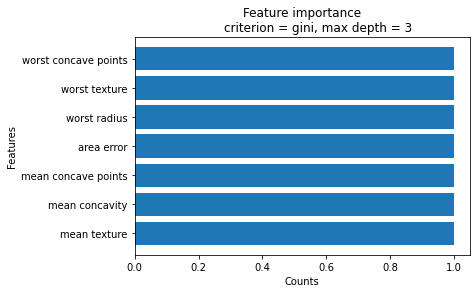

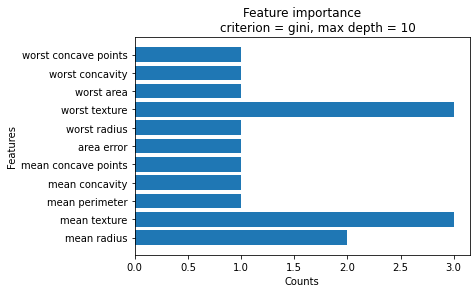

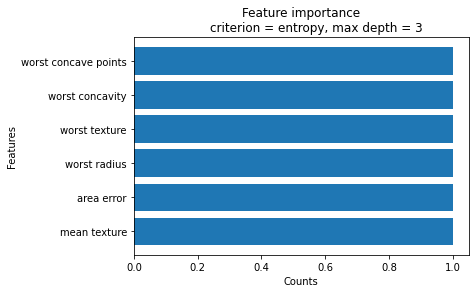

In [9]:
clf_depth3.feature_counter(x_train_np)
clf_depth10.feature_counter(x_train_np)
clf_entropy.feature_counter(x_train_np)
# The feature which is not in the figure is not used


# Question 4

In [10]:
class RandomForest():
    def __init__(self, n_estimators, max_features,
                 bootstrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        # If the max_features is not integer
        # I round it
        self.max_features = round(max_features)
        self.bootstrap = bootstrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree_list = []

    # Build the random forest
    def build(self, X, y):
        # If bootstrap is true, the data may be reused
        if self.bootstrap is True:
            for b in range(self.n_estimators):
                # I random chose max_features features every time
                X_ = X[:, random.sample(range(X.shape[1]),
                                        self.max_features)]
                # I random chose 120 datas to build decision tree
                random_choose = random.sample(range(X.shape[0]), 120)
                X_ = X[random_choose, :]
                y_ = y[random_choose]
                clf = DecisionTree(self.criterion, self.max_depth)
                clf.fit(X_, y_)
                self.tree_list.append(clf)  # Record the decision tree
        else:  # If bootstrap is not true, the data will not be reused
            random_train_list = np.arange(X.shape[1])
            random.shuffle(random_train_list)
            # I divide datas into n_estimators parts
            n = round(X.shape[0] / self.n_estimators)
            for b in range(self.n_estimators - 1):
                # I random chose max_features feature every time
                X_ = X[:, random.sample(range(X.shape[1]),
                                        self.max_features)]
                X_ = X[b*n:(b+1)*n, :]
                y_ = y[b*n:(b+1)*n]
                clf = DecisionTree(self.criterion, self.max_depth)
                clf.fit(X_, y_)
                self.tree_list.append(clf)
            X_ = X[(self.n_estimators-1)*n:, :]
            y_ = y[(self.n_estimators-1)*n:]
            clf = DecisionTree(self.criterion, self.max_depth)
            clf.fit(X_, y_)
            self.tree_list.append(clf)  # Record the decision tree

    def predict(self, test):
        result_vote = np.zeros(test.shape[0])
        for b in range(self.n_estimators):
            predict = self.tree_list[b].predict(test)
            result_vote = result_vote + np.array(predict)
        # Calculate the probability of class
        # Because there are two classes for in this assignment
        # If probability >= 0.5, it belongs to class 1
        # else it belongs to class 0
        result_vote = result_vote / self.n_estimators
        for i in range(test.shape[0]):
            if result_vote[i] < 0.5:
                result_vote[i] = 0
            else:
                result_vote[i] = 1
        return result_vote


## Question 4.1

In [11]:
clf_10tree = RandomForest(n_estimators=10,
                          max_features=np.sqrt(x_train.shape[1]))
clf_10tree.build(x_train_np, y_train_np)
predict_10tree = clf_10tree.predict(x_test_np)
acc_10tree = accuracy_score(predict_10tree, y_test_np)
print(f"criterion: gini, estimators = 10, bootstrap = True.\n\
Accuracy of test-set = {acc_10tree}")

clf_10tree = RandomForest(n_estimators=10,
                          max_features=np.sqrt(x_train.shape[1]), bootstrap=True, criterion='gini', max_depth=None)
clf_10tree.build(x_train_np, y_train_np)
predict_10tree = clf_10tree.predict(x_test_np)
acc_10tree = accuracy_score(predict_10tree, y_test_np)
print(f"criterion: gini, estimators = 10, bootstrap = False.\n\
Accuracy of test-set = {acc_10tree}")

# This case may spend a little much time
clf_100tree = RandomForest(n_estimators=100,
                           max_features=np.sqrt(x_train.shape[1]))
clf_100tree.build(x_train_np, y_train_np)
predict_100tree = clf_100tree.predict(x_test_np)
acc_100tree = accuracy_score(predict_100tree, y_test_np)
print(f"criterion: gini, estimators = 100, bootstrap = True.\n\
Accuracy of test-set = {acc_100tree}")

# P.S. It may spend some time calculating when n_estimators is large.


<ipython-input-6-9388fefeb545>:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
<ipython-input-6-9388fefeb545>:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))


criterion: gini, estimators = 10, bootstrap = True.
Accuracy of test-set = 0.9370629370629371
criterion: gini, estimators = 10, bootstrap = False.
Accuracy of test-set = 0.9300699300699301
criterion: gini, estimators = 100, bootstrap = True.
Accuracy of test-set = 0.951048951048951


## Question 4.2

In [12]:
clf_random_features = RandomForest(n_estimators=10,
                                   max_features=np.sqrt(x_train.shape[1]))
clf_random_features.build(x_train_np, y_train_np)
predict_random_features = clf_random_features.predict(x_test_np)
acc_random_features = accuracy_score(predict_random_features, y_test_np)
print(f"criterion: gini, estimators = 10 with random features.\n\
Accuracy of test-set = {acc_random_features}")

clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_all_features.build(x_train_np, y_train_np)
predict_all_features = clf_all_features.predict(x_test_np)
acc_all_features = accuracy_score(predict_all_features, y_test_np)
print(f"criterion: gini, estimators = 10 with all features.\n\
Accuracy of test-set = {acc_all_features}")


<ipython-input-6-9388fefeb545>:24: RuntimeWarning: divide by zero encountered in log2
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))
<ipython-input-6-9388fefeb545>:24: RuntimeWarning: invalid value encountered in double_scalars
  return -(p_0 * np.log2(p_0) + p_1 * np.log2(p_1))


criterion: gini, estimators = 10 with random features.
Accuracy of test-set = 0.951048951048951
criterion: gini, estimators = 10 with all features.
Accuracy of test-set = 0.972027972027972
